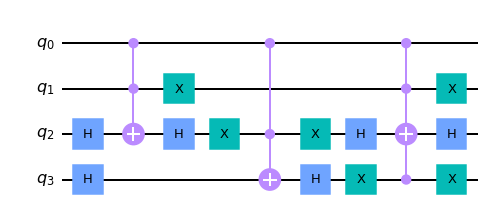

In [5]:
from qiskit import QuantumCircuit, Aer, BasicAer, transpile, assemble
from qiskit.aqua import QuantumInstance
from qiskit.aqua.components.oracles import TruthTableOracle
from qiskit.aqua.algorithms import Grover
from qiskit.visualization import plot_histogram
import numpy as np
import math


def example_grover_oracle():
    """Small circuit with 5/16 solutions"""
    # Do circuit
    qc = QuantumCircuit(4)
    # Oracle
    qc.h([2,3])
    qc.ccx(0,1,2)
    qc.h(2)
    qc.x(2)
    qc.ccx(0,2,3)
    qc.x(2)
    qc.h(3)
    qc.x([1,3])
    qc.h(2)
    qc.mct([0,1,3],2)
    qc.x([1,3])
    qc.h(2)
    
    return qc

## Main
t = 4   # no. of counting qubits
n = 4   # no. of searching qubits

# https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.html
qc = QuantumCircuit(n+t, t) # Circuit with n+t qubits and t classical bits

oracle = example_grover_oracle()
oracle.draw()

In [6]:
# https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.Grover.html
grover = Grover(oracle)

#grover.draw()

TypeError: Unsupported type "<class 'NoneType'>" of is_good_state

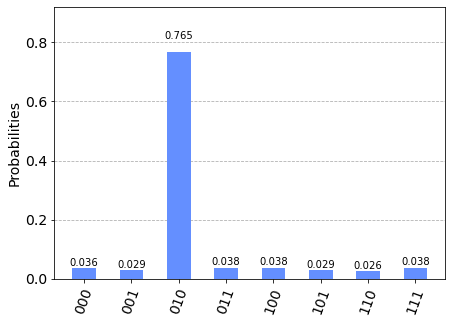

In [113]:
result = grover.run(QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=1024))
plot_histogram(result.measurement)

In [114]:

grover_iteration = grover.grover_operator.to_gate()
ctl_grover_iteration = grover_iteration.control()
ctl_grover_iteration.label = "Ctl GrovIt"

In [115]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

qft_dagger = qft(t).to_gate().inverse()
qft_dagger.label = "QFT†"

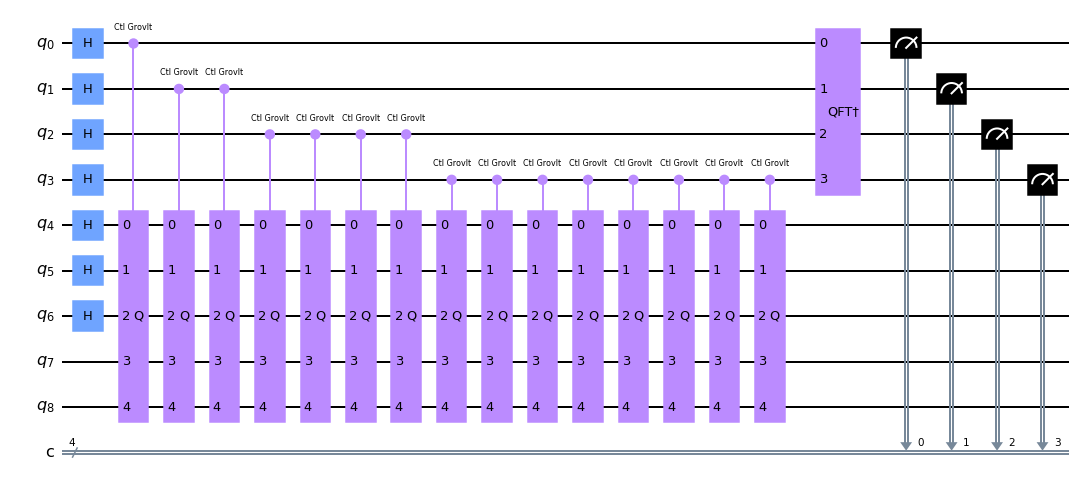

In [116]:

# https://qiskit.org/textbook/ch-algorithms/quantum-counting.html#2.4-Putting-it-Together-

# Initialise all qubits to |+>
for qubit in range(t+n):
    qc.h(qubit)

 # Begin controlled Grover iterations
iterations = 1
for qubit in range(t):
    for i in range(iterations):
        qc.append(ctl_grover_iteration, [qubit] + [*range(t, n+t+2)])
    iterations *= 2


# Do inverse QFT on counting qubits
qc.append(qft_dagger, range(t))

qc.measure(range(t), range(t))

# Display the circuit
qc.draw()   

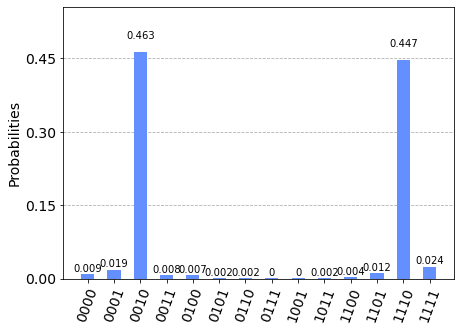

In [117]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_sim)
qobj = assemble(transpiled_qc)
job = qasm_sim.run(qobj)
hist = job.result().get_counts()
plot_histogram(hist)

In [118]:
measured_str = max(hist, key=hist.get)
measured_int = int(measured_str,2)
print("Register Output = %i" % measured_int)
theta = (measured_int/(2**t))*math.pi*2
print("Theta = %.5f" % theta)

N = 2**(n-1)
M = N * (math.sin(theta/2)**2)
print("No. of Solutions = %.1f" % (N-M))

Register Output = 2
Theta = 0.78540
No. of Solutions = 3.4
